# Lyricist Sentiments
A project by Samuel Peter (samuel.peter.25@dartmouth.edu)
June 1, 2024

This project aims to analyze sentiment, focusing on primary emotions, expressed in popular music lyrics spanning from the 1950s to modern hits. By leveraging a combination of lexicon-based sentiment analysis using VADER and statistical techniques like ARIMA and the Mann-Kendall Trend Test, the study seeks to uncover how sentiments in music have evolved over time. Through the analysis of sentiment trends and correlations with specific time periods, this project aims to shed light on the cultural attitudes, emotional expressions, and evolving trends in "successful" popular music.


# Part 1: Vader Sentiment Analysis

In [1]:
# Install requiered libraries
from google.colab import files
!pip install requests
!pip install tqdm
!pip install vaderSentiment
!pip install pymannkendall
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 26.9 MB/s eta 0:00:00


In [2]:
# Upload data file of Billboard Hot 100 songs
uploaded = files.upload()

Saving BillboardHot100CleanedData.csv to BillboardHot100CleanedData.csv


In [3]:
# Import required packages
import pandas as pd
import json
import requests
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import re
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pymannkendall as mk

In [4]:
# Get file name and print the dataframe head
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print(df.head())

                 Date            Artist  \
0      August 4, 1958      Ricky Nelson   
1     August 18, 1958  Domenico Modugno   
2     August 25, 1958      The Elegants   
3  September 29, 1958     Tommy Edwards   
4   November 10, 1958     Conway Twitty   

                                      Song  
0                         Poor Little Fool  
1  Volare (Nel blu dipinto di blu)♪ (1958)  
2                              Little Star  
3                     It's All in the Game  
4                   It's Only Make Believe  


In [5]:
# Function to clean the "Song" column and remove special characters
def clean_song_name(song):
    # Match the part of the string that occurs before the ♪
    if '♪' in song:
      song = song.split('♪')
      return song[0]
    else:
      return song

In [6]:
# Apply the function to the "Song" column
df['Song'] = df['Song'].apply(clean_song_name)
# Display the DataFrame
print(df.head())

                 Date            Artist                             Song
0      August 4, 1958      Ricky Nelson                 Poor Little Fool
1     August 18, 1958  Domenico Modugno  Volare (Nel blu dipinto di blu)
2     August 25, 1958      The Elegants                      Little Star
3  September 29, 1958     Tommy Edwards             It's All in the Game
4   November 10, 1958     Conway Twitty           It's Only Make Believe


In [7]:
# Initialize empty lists to store songs without lyrics and all lyrics
songs_without_lyrics = []
all_lyrics = []

# Get the total number of rows in the DataFrame
total_rows = len(df)

# Initialize a progress bar to track the progress of fetching lyrics
progress_bar = tqdm(total=total_rows, desc='Fetching Lyrics', position=0, leave=True)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract the date, artist, and song name from the current row
    date = row['Date']
    artist = row['Artist']
    song = row['Song']

    try:
        # Construct the API URL using the artist and song name
        url = 'https://api.lyrics.ovh/v1/' + artist + '/' + song

        # Make a GET request to the API
        response = requests.get(url)

        # Check for HTTP errors (raise an exception for bad responses)
        response.raise_for_status()

        # Parse the JSON response from the API
        json_data = response.json()  # Use .json() to directly get the JSON content

        # Try to access the 'lyrics' key in the JSON data
        lyrics = json_data.get('lyrics', None)

        # Append the lyrics to the all_lyrics list
        all_lyrics.append(lyrics)

    except requests.exceptions.RequestException as e:
        # Handle HTTP errors by appending "No lyrics" to the all_lyrics list
        all_lyrics.append("No lyrics")  # Ensure list length matches DataFrame rows

        # Add the song to the songs_without_lyrics list
        songs_without_lyrics.append(song)

    # Update the progress bar for each iteration
    progress_bar.update(1)

# Close the progress bar after the loop completes
progress_bar.close()

# Print the lengths of the lists to debug
print()
print(f"Length of all_lyrics: {len(all_lyrics)}")
print(f"Length of DataFrame: {len(df)}")

# Check if the length of all_lyrics matches the length of the DataFrame
if len(all_lyrics) == len(df):
    # If they match, add the all_lyrics list as a new column in the DataFrame
    df['Lyrics'] = all_lyrics
    print("Column 'Lyrics' added successfully.")
else:
    # If there's a mismatch, print an error message
    print("Error: Length mismatch between all_lyrics and DataFrame.")

Fetching Lyrics: 100%|██████████| 1177/1177 [12:29<00:00,  1.57it/s]


Length of all_lyrics: 1177
Length of DataFrame: 1177
Column 'Lyrics' added successfully.


In [8]:
# Check dataframe head
print(df.head())

                 Date            Artist                             Song  \
0      August 4, 1958      Ricky Nelson                 Poor Little Fool   
1     August 18, 1958  Domenico Modugno  Volare (Nel blu dipinto di blu)   
2     August 25, 1958      The Elegants                      Little Star   
3  September 29, 1958     Tommy Edwards             It's All in the Game   
4   November 10, 1958     Conway Twitty           It's Only Make Believe   

                                              Lyrics  
0  I used to play around with hearts that hastene...  
1  Paroles de la chanson Volare par Domenico Modu...  
2  Paroles de la chanson Little Star par The Eleg...  
3                                          No lyrics  
4  People see us everywhere they all think you re...  


In [9]:
# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Split the lyrics of the current row into lines
    lines = row['Lyrics'].splitlines()

    # Check if the first line contains 'Paroles de la chanson' and remove it if true
    if 'Paroles de la chanson' in lines[0]:
        lines = lines[1:]  # Remove the first line

    # Join the remaining lines back into a single string and update the DataFrame
    df.at[index, 'Lyrics'] = ''.join(lines)

# Print the first few rows of the DataFrame to verify the changes
print(df.head())

                 Date            Artist                             Song  \
0      August 4, 1958      Ricky Nelson                 Poor Little Fool   
1     August 18, 1958  Domenico Modugno  Volare (Nel blu dipinto di blu)   
2     August 25, 1958      The Elegants                      Little Star   
3  September 29, 1958     Tommy Edwards             It's All in the Game   
4   November 10, 1958     Conway Twitty           It's Only Make Believe   

                                              Lyrics  
0  I used to play around with hearts that hastene...  
1  Penso che un sogno cosi` non ritorni mai piu`,...  
2  Where are you little star?(Where are you?)Whoa...  
3                                          No lyrics  
4  People see us everywhere they all think you re...  


In [10]:
# Create a mask to identify rows where the song lyrics is not 'No lyrics'
mask = df['Lyrics'] != 'No lyrics'

# Drop the rows that match the mask
df_filtered = df[mask]

# Print the filtered DataFrame
print(df_filtered.head())

                Date             Artist                             Song  \
0     August 4, 1958       Ricky Nelson                 Poor Little Fool   
1    August 18, 1958   Domenico Modugno  Volare (Nel blu dipinto di blu)   
2    August 25, 1958       The Elegants                      Little Star   
4  November 10, 1958      Conway Twitty           It's Only Make Believe   
5  November 17, 1958  The Kingston Trio                       Tom Dooley   

                                              Lyrics  
0  I used to play around with hearts that hastene...  
1  Penso che un sogno cosi` non ritorni mai piu`,...  
2  Where are you little star?(Where are you?)Whoa...  
4  People see us everywhere they all think you re...  
5  Hang down your head, Tom DooleyHang down your ...  


In [11]:
print(f"Length of df_filtered is                                      {len(df_filtered)}")
print(f"Lenght of songs without lyrics is                             {len(songs_without_lyrics)}")
print(f"Length of df should be 1177(and the sum of the above) and is  {len(df)}")

# Function to get the date of a song given its name
def get_song_date(song_name):
    row = df[df['Song'] == song_name]
    if not row.empty:
        return row.iloc[0]['Date']
    return None

# Create a dictionary to store the count of songs without lyrics per year
songs_without_lyrics_per_year = {}

# Process the list of songs without lyrics
for song in songs_without_lyrics:
    date = get_song_date(song)
    if date:
        year = date.split()[-1]
        if year not in songs_without_lyrics_per_year:
            songs_without_lyrics_per_year[year] = 0
        songs_without_lyrics_per_year[year] += 1

# Print the hash table
print("Hash table of years and number of songs lyrics in df that lyrics were unavailble for on lyrics.ovh: ")
print(songs_without_lyrics_per_year)

Length of df_filtered is                                      877
Lenght of songs without lyrics is                             300
Length of df should be 1177(and the sum of the above) and is  1177
Hash table of years and number of songs lyrics in df that lyrics were unavailble for on lyrics.ovh: 
{'1958': 2, '1959': 4, '1960': 3, '1961': 4, '1962': 8, '1963': 10, '1964': 2, '1965': 4, '1966': 10, '1967': 5, '1968': 5, '1969': 7, '1970': 8, '1971': 7, '1972': 2, '1973': 4, '1974': 7, '1975': 9, '1976': 5, '1977': 4, '1978': 4, '1979': 5, '1980': 1, '1981': 3, '1982': 2, '1983': 3, '1985': 3, '1986': 4, '1987': 8, '1988': 3, '1990': 2, '1991': 2, '1992': 1, '1993': 2, '1994': 2, '1995': 2, '1996': 4, '1997': 4, '1998': 4, '1999': 4, '2000': 4, '2001': 5, '2002': 3, '2003': 7, '2004': 7, '2005': 2, '2006': 7, '2007': 5, '2008': 4, '2009': 5, '2010': 8, '2011': 6, '2012': 2, '2013': 5, '2014': 3, '2015': 3, '2016': 6, '2017': 7, '2018': 4, '2019': 4, '2020': 10, '2021': 5, '2022': 4, '20

In [12]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to analyze sentiment
def analyze_sentiment(lyrics):
    sentiment = analyzer.polarity_scores(lyrics)
    return sentiment['compound']

# Apply sentiment analysis to the 'Lyrics' column
df_filtered['Sentiment'] = df_filtered['Lyrics'].apply(analyze_sentiment)

# Print the updated DataFrame
print(df_filtered.head())

                Date             Artist                             Song  \
0     August 4, 1958       Ricky Nelson                 Poor Little Fool   
1    August 18, 1958   Domenico Modugno  Volare (Nel blu dipinto di blu)   
2    August 25, 1958       The Elegants                      Little Star   
4  November 10, 1958      Conway Twitty           It's Only Make Believe   
5  November 17, 1958  The Kingston Trio                       Tom Dooley   

                                              Lyrics  Sentiment  
0  I used to play around with hearts that hastene...    -0.9978  
1  Penso che un sogno cosi` non ritorni mai piu`,...     0.0000  
2  Where are you little star?(Where are you?)Whoa...     0.9708  
4  People see us everywhere they all think you re...     0.9776  
5  Hang down your head, Tom DooleyHang down your ...    -0.7506  


<ipython-input-12-63b1f4497d9a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Sentiment'] = df_filtered['Lyrics'].apply(analyze_sentiment)


In [13]:
# Extract year from 'Date' column
df_filtered['Year'] = pd.to_datetime(df_filtered['Date']).dt.year

# Verify the updates to the dataframe
print(df_filtered.head())

                Date             Artist                             Song  \
0     August 4, 1958       Ricky Nelson                 Poor Little Fool   
1    August 18, 1958   Domenico Modugno  Volare (Nel blu dipinto di blu)   
2    August 25, 1958       The Elegants                      Little Star   
4  November 10, 1958      Conway Twitty           It's Only Make Believe   
5  November 17, 1958  The Kingston Trio                       Tom Dooley   

                                              Lyrics  Sentiment  Year  
0  I used to play around with hearts that hastene...    -0.9978  1958  
1  Penso che un sogno cosi` non ritorni mai piu`,...     0.0000  1958  
2  Where are you little star?(Where are you?)Whoa...     0.9708  1958  
4  People see us everywhere they all think you re...     0.9776  1958  
5  Hang down your head, Tom DooleyHang down your ...    -0.7506  1958  


<ipython-input-13-2efad6a90fb3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Year'] = pd.to_datetime(df_filtered['Date']).dt.year


In [14]:
# Function to map year to 5-year windows
def map_to_5year_window(year):
    return f"{year // 5 * 5}-{year // 5 * 5 + 4}"

# Apply the function to create a new column for 5-year windows
df_filtered.loc[:, '5YearWindow'] = df_filtered['Year'].apply(map_to_5year_window)
# Print the filtered DataFrame to verify the new column
print("Filtered DataFrame with 5-Year Windows:")
print(df_filtered.head())

Filtered DataFrame with 5-Year Windows:
                Date             Artist                             Song  \
0     August 4, 1958       Ricky Nelson                 Poor Little Fool   
1    August 18, 1958   Domenico Modugno  Volare (Nel blu dipinto di blu)   
2    August 25, 1958       The Elegants                      Little Star   
4  November 10, 1958      Conway Twitty           It's Only Make Believe   
5  November 17, 1958  The Kingston Trio                       Tom Dooley   

                                              Lyrics  Sentiment  Year  \
0  I used to play around with hearts that hastene...    -0.9978  1958   
1  Penso che un sogno cosi` non ritorni mai piu`,...     0.0000  1958   
2  Where are you little star?(Where are you?)Whoa...     0.9708  1958   
4  People see us everywhere they all think you re...     0.9776  1958   
5  Hang down your head, Tom DooleyHang down your ...    -0.7506  1958   

  5YearWindow  
0   1955-1959  
1   1955-1959  
2   1955-1959  


<ipython-input-14-e6ea4b43a873>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, '5YearWindow'] = df_filtered['Year'].apply(map_to_5year_window)


In [29]:
# Define the data
missing_songs_per_year = songs_without_lyrics_per_year.copy()

# Extract unique 5-year windows from the dataframe
five_year_windows = df_filtered['5YearWindow'].unique()

# Convert the window strings to tuples of start and end years
five_year_windows_tuples = [(int(window.split('-')[0]), int(window.split('-')[1])) for window in five_year_windows]

# Function to calculate the total missing songs for each window
def calculate_missing_songs(window, missing_songs):
    start_year, end_year = window
    total_missing = sum(missing_songs.get(str(year), 0) for year in range(start_year, end_year + 1))
    return total_missing

# Calculate missing songs for each window
missing_songs_per_window = {f"{start}-{end}": calculate_missing_songs((start, end), missing_songs_per_year)
                            for start, end in five_year_windows_tuples}

# Print each window and the number of missing songs in each window
for window, missing_count in missing_songs_per_window.items():
    print(f"The 5-year window {window} has {missing_count} missing songs.")


The 5-year window 1955-1959 has 6 missing songs.
The 5-year window 1960-1964 has 27 missing songs.
The 5-year window 1965-1969 has 31 missing songs.
The 5-year window 1970-1974 has 28 missing songs.
The 5-year window 1975-1979 has 27 missing songs.
The 5-year window 1980-1984 has 9 missing songs.
The 5-year window 1985-1989 has 18 missing songs.
The 5-year window 1990-1994 has 9 missing songs.
The 5-year window 1995-1999 has 18 missing songs.
The 5-year window 2000-2004 has 26 missing songs.
The 5-year window 2005-2009 has 23 missing songs.
The 5-year window 2010-2014 has 24 missing songs.
The 5-year window 2015-2019 has 24 missing songs.
The 5-year window 2020-2024 has 30 missing songs.


In [15]:
# Group by the 5-year window and aggregate the sentiment scores
sentiment_by_window = df_filtered.groupby('5YearWindow')['Sentiment'].mean().reset_index()

# Print the result
print("\nAggregated Sentiment by 5-Year Window:")
print(sentiment_by_window)


Aggregated Sentiment by 5-Year Window:
   5YearWindow  Sentiment
0    1955-1959   0.471824
1    1960-1964   0.608964
2    1965-1969   0.576754
3    1970-1974   0.515647
4    1975-1979   0.588422
5    1980-1984   0.588459
6    1985-1989   0.509203
7    1990-1994   0.691827
8    1995-1999   0.672200
9    2000-2004   0.646052
10   2005-2009   0.286420
11   2010-2014   0.630941
12   2015-2019   0.113277
13   2020-2024   0.288004


In [16]:
# Group by the 5-year window to get the list of songs
songs_by_window = df_filtered.groupby('5YearWindow')['Song'].apply(list).reset_index()

# Merge the two DataFrames on the 5-year window column
sentiment_by_window = pd.merge(sentiment_by_window, songs_by_window, on='5YearWindow')

# Print the result
print("\nAggregated Sentiment by 5-Year Window with Songs:")
print(sentiment_by_window)


Aggregated Sentiment by 5-Year Window with Songs:
   5YearWindow  Sentiment                                               Song
0    1955-1959   0.471824  [Poor Little Fool, Volare (Nel blu dipinto di ...
1    1960-1964   0.608964  [El Paso, Running Bear, Teen Angel, Theme from...
2    1965-1969   0.576754  [Downtown, You've Lost That Lovin' Feelin', My...
3    1970-1974   0.515647  [I Want You Back, Venus, Let It Be, ABC, Every...
4    1975-1979   0.588422  [Lucy in the Sky with Diamonds, Mandy, Please ...
5    1980-1984   0.588459  [Please Don't Go, Rock with You, Crazy Little ...
6    1985-1989   0.509203  [I Want to Know What Love Is, Can't Fight This...
7    1990-1994   0.691827  [How Am I Supposed to Live Without You, Escapa...
8    1995-1999   0.672200  [Creep, Take A Bow, This Is How We Do It, Have...
9    2000-2004   0.646052  [What a Girl Wants, I Knew I Loved You, Amazed...
10   2005-2009   0.286420  [Let Me Love You, Hollaback Girl, We Belong To...
11   2010-2014   0.630941

#Part 2: Sentiment analysis with NRC-Emotion-Lexicon-Wordlevel-v0.92

In [19]:
# Upload NRC-Emotion-Lexicon-Wordlevel file
uploaded = files.upload()

Saving NRC-Emotion-Lexicon-Wordlevel-v0.92.txt to NRC-Emotion-Lexicon-Wordlevel-v0.92.txt


In [20]:
filename = "NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
feelings_dict = {}
primary_feelings = []

# Open the uploaded file in read mode
with open(filename, 'r') as file:
  for line in file:
    # Assuming 'file' is the file object opened for reading
    words = line.split()

    # Process the words as needed
    #print(words)
    #if words is not empty
    if words:
      if words[2] == '1':   #if the word also has an emotion attached to it
        if words[0] in feelings_dict:                 #Check if the word already exists in the feelings dictionary
          feelings_dict[words[0]].append(words[1])    #If so, attach feeling to the list of associated feelings for the particular word
        else:
          feelings_dict[words[0]] = [words[1]]        #Else, create a new key in the dictionary with the word and set the value to be a list containing the associated feeling

      #Condition to create a list of all possible feelings for future reference
      if not words[1] in primary_feelings:
        primary_feelings.append(words[1])

print(feelings_dict)
print(primary_feelings)

{'abacus': ['trust'], 'abandon': ['fear', 'negative', 'sadness'], 'abandoned': ['anger', 'fear', 'negative', 'sadness'], 'abandonment': ['anger', 'fear', 'negative', 'sadness', 'surprise'], 'abba': ['positive'], 'abbot': ['trust'], 'abduction': ['fear', 'negative', 'sadness', 'surprise'], 'aberrant': ['negative'], 'aberration': ['disgust', 'negative'], 'abhor': ['anger', 'disgust', 'fear', 'negative'], 'abhorrent': ['anger', 'disgust', 'fear', 'negative'], 'ability': ['positive'], 'abject': ['disgust', 'negative'], 'abnormal': ['disgust', 'negative'], 'abolish': ['anger', 'negative'], 'abolition': ['negative'], 'abominable': ['disgust', 'fear', 'negative'], 'abomination': ['anger', 'disgust', 'fear', 'negative'], 'abort': ['negative'], 'abortion': ['disgust', 'fear', 'negative', 'sadness'], 'abortive': ['negative', 'sadness'], 'abovementioned': ['positive'], 'abrasion': ['negative'], 'abrogate': ['negative'], 'abrupt': ['surprise'], 'abscess': ['negative', 'sadness'], 'absence': ['fear

In [21]:
# Initialize an empty dictionary to store emotions for each era
eras_emotions = {}

# Iterate over each primary feeling and initialize its count to 0
for feeling in primary_feelings:
    eras_emotions[feeling] = 0

# Store the initialized emotions dictionary as the default emotion dictionary
default_emotion = eras_emotions
print(default_emotion)  # Print the default emotion dictionary for debugging

# Create a list of the default emotions dictionary, with one entry for each row in sentiment_by_window
eras_emotions = [eras_emotions] * len(sentiment_by_window)

# Add the list of emotions dictionaries as a new column 'Eras Emotions' in the sentiment_by_window DataFrame
sentiment_by_window['Eras Emotions'] = eras_emotions

# Print the sentiment_by_window DataFrame to verify the changes
print(sentiment_by_window)

{'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'negative': 0, 'positive': 0, 'sadness': 0, 'surprise': 0, 'trust': 0}
   5YearWindow  Sentiment                                               Song  \
0    1955-1959   0.471824  [Poor Little Fool, Volare (Nel blu dipinto di ...   
1    1960-1964   0.608964  [El Paso, Running Bear, Teen Angel, Theme from...   
2    1965-1969   0.576754  [Downtown, You've Lost That Lovin' Feelin', My...   
3    1970-1974   0.515647  [I Want You Back, Venus, Let It Be, ABC, Every...   
4    1975-1979   0.588422  [Lucy in the Sky with Diamonds, Mandy, Please ...   
5    1980-1984   0.588459  [Please Don't Go, Rock with You, Crazy Little ...   
6    1985-1989   0.509203  [I Want to Know What Love Is, Can't Fight This...   
7    1990-1994   0.691827  [How Am I Supposed to Live Without You, Escapa...   
8    1995-1999   0.672200  [Creep, Take A Bow, This Is How We Do It, Have...   
9    2000-2004   0.646052  [What a Girl Wants, I Knew I Loved 

In [22]:
# Define a helper function to get the lyrics of a specific song
def get_lyrics(df, song_name):
    # Filter the DataFrame to find the row corresponding to the given song name
    song_row = df[df['Song'] == song_name]

    # Return the lyrics from the first row of the filtered DataFrame
    return song_row.iloc[0]['Lyrics']

In [23]:
# Iterate over each row in the sentiment_by_window DataFrame
for index, row in sentiment_by_window.iterrows():
    # Get the list of songs for the current row (era)
    songs = row['Song']

    # Initialize a dictionary to store the emotions for the current era, with all primary feelings set to 0
    era_emotion = {feeling: 0 for feeling in primary_feelings}

    # Iterate over each song in the list of songs for the current era
    for song in songs:
        # Get the lyrics for the current song using the helper function
        lyrics_for_analysis = get_lyrics(df_filtered, song)

        # Remove all non-alphabetic characters from the lyrics and replace them with spaces
        lyrics_for_analysis = re.sub(r'[^a-zA-Z]+', ' ', lyrics_for_analysis)

        # Split the lyrics into a set of unique words (converted to lowercase)
        words = set(lyrics_for_analysis.lower().split())

        # Initialize a temporary dictionary to store the emotions for the current song, with all primary feelings set to 0
        temp_emotions = {feeling: 0 for feeling in primary_feelings}

        # Iterate over each word in the set of words from the lyrics
        for word in words:
            if word in feelings_dict:  # Check if the word exists in the feelings dictionary
                # If so, iterate through the associated feelings for the word
                for feeling in feelings_dict[word]:
                    # Update the appropriate emotional score in the temporary dictionary
                    temp_emotions[feeling] += 1

        # Add the temporary emotional scores to the era's emotional scores
        for feeling in primary_feelings:
            era_emotion[feeling] += temp_emotions[feeling]

    # Print the emotions for the current era for debugging purposes
    print("Emotion of " + row['5YearWindow'])
    print(era_emotion)
    print()

    # Update the 'Eras Emotions' column in the sentiment_by_window DataFrame with the emotions for the current era
    sentiment_by_window.at[index, 'Eras Emotions'] = era_emotion

    # Reset the era_emotion dictionary for the next iteration; this is useful if the cell is being rerun without running the above cell, e.g., during debugging sessions
    era_emotion = {feeling: 0 for feeling in primary_feelings}

Emotion of 1955-1959
{'anger': 17, 'anticipation': 35, 'disgust': 16, 'fear': 19, 'joy': 55, 'negative': 52, 'positive': 71, 'sadness': 33, 'surprise': 20, 'trust': 41}

Emotion of 1960-1964
{'anger': 76, 'anticipation': 170, 'disgust': 50, 'fear': 110, 'joy': 228, 'negative': 190, 'positive': 335, 'sadness': 129, 'surprise': 103, 'trust': 194}

Emotion of 1965-1969
{'anger': 63, 'anticipation': 169, 'disgust': 48, 'fear': 90, 'joy': 221, 'negative': 191, 'positive': 337, 'sadness': 110, 'surprise': 115, 'trust': 194}

Emotion of 1970-1974
{'anger': 119, 'anticipation': 246, 'disgust': 77, 'fear': 161, 'joy': 295, 'negative': 284, 'positive': 472, 'sadness': 186, 'surprise': 141, 'trust': 292}

Emotion of 1975-1979
{'anger': 147, 'anticipation': 277, 'disgust': 99, 'fear': 164, 'joy': 317, 'negative': 329, 'positive': 494, 'sadness': 192, 'surprise': 161, 'trust': 288}

Emotion of 1980-1984
{'anger': 97, 'anticipation': 171, 'disgust': 50, 'fear': 94, 'joy': 184, 'negative': 200, 'posi

In [24]:
# Verify the changes to the dataframe
print(sentiment_by_window)

   5YearWindow  Sentiment                                               Song  \
0    1955-1959   0.471824  [Poor Little Fool, Volare (Nel blu dipinto di ...   
1    1960-1964   0.608964  [El Paso, Running Bear, Teen Angel, Theme from...   
2    1965-1969   0.576754  [Downtown, You've Lost That Lovin' Feelin', My...   
3    1970-1974   0.515647  [I Want You Back, Venus, Let It Be, ABC, Every...   
4    1975-1979   0.588422  [Lucy in the Sky with Diamonds, Mandy, Please ...   
5    1980-1984   0.588459  [Please Don't Go, Rock with You, Crazy Little ...   
6    1985-1989   0.509203  [I Want to Know What Love Is, Can't Fight This...   
7    1990-1994   0.691827  [How Am I Supposed to Live Without You, Escapa...   
8    1995-1999   0.672200  [Creep, Take A Bow, This Is How We Do It, Have...   
9    2000-2004   0.646052  [What a Girl Wants, I Knew I Loved You, Amazed...   
10   2005-2009   0.286420  [Let Me Love You, Hollaback Girl, We Belong To...   
11   2010-2014   0.630941  [Tik Tok, Rud

# Part 3: Validation

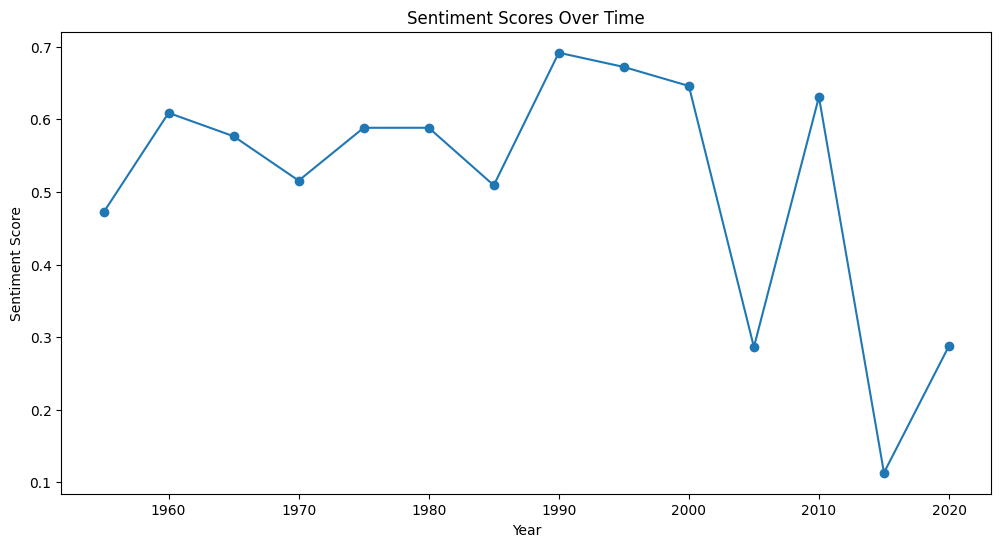

In [25]:
# Convert the '5YearWindow' column to start year integers
# Apply a lambda function to split the window and take the start year part, then convert to integers
sentiment_by_window['5YearWindow'] = sentiment_by_window['5YearWindow'].apply(lambda x: x.split('-')[0]).astype(int)

# Create a figure for the plot with a specified size
plt.figure(figsize=(12, 6))

# Plot the sentiment scores over time
# Use '5YearWindow' as the x-axis and 'Sentiment' as the y-axis, with circle markers for data points
plt.plot(sentiment_by_window['5YearWindow'], sentiment_by_window['Sentiment'], marker='o')

# Label the x-axis
plt.xlabel('Year')

# Label the y-axis
plt.ylabel('Sentiment Score')

# Set the title of the plot
plt.title('Sentiment Scores Over Time')

# Display the plot
plt.show()

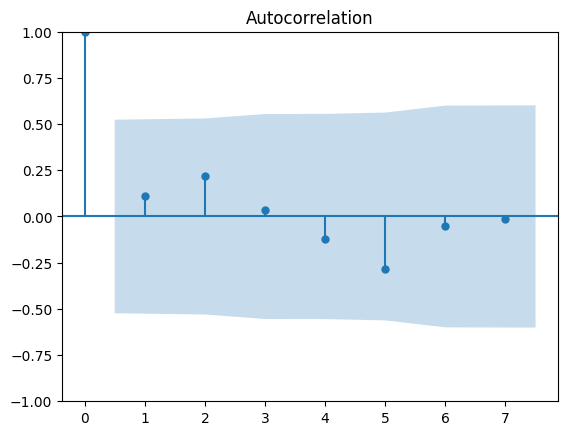

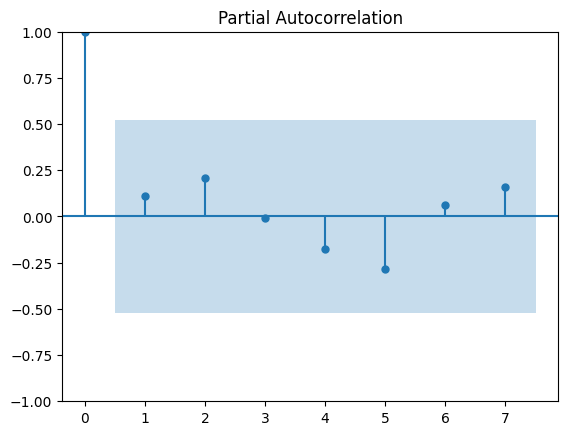

                               SARIMAX Results                                
Dep. Variable:              Sentiment   No. Observations:                   14
Model:                 ARIMA(1, 1, 1)   Log Likelihood                   5.251
Date:                Mon, 03 Jun 2024   AIC                             -4.503
Time:                        12:53:03   BIC                             -2.808
Sample:                             0   HQIC                            -4.851
                                 - 14                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6551      0.504     -1.300      0.194      -1.643       0.333
ma.L1         -0.0195      0.947     -0.021      0.984      -1.876       1.837
sigma2         0.0249      0.011      2.285      0.0

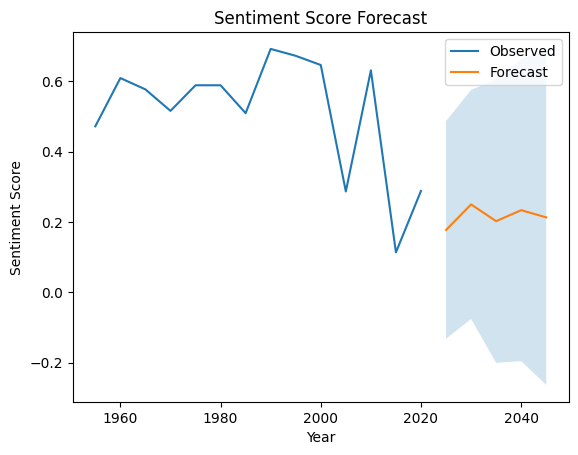

In [26]:
# Convert 5YearWindow to string and extract the start year
sentiment_by_window['5YearWindow'] = sentiment_by_window['5YearWindow'].astype(str)
sentiment_by_window['StartYear'] = sentiment_by_window['5YearWindow'].apply(lambda x: int(x.split('-')[0]))

# Plot ACF and PACF to identify p and q
plot_acf(sentiment_by_window['Sentiment'])
plot_pacf(sentiment_by_window['Sentiment'])
plt.show()

# Fit ARIMA model (choose p, d, q based on ACF/PACF analysis)
p, d, q = 1, 1, 1  # example values, adjust based on your ACF/PACF analysis
model = ARIMA(sentiment_by_window['Sentiment'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# Calculate AIC, MAE, and RMSE
aic = model_fit.aic
mae = np.mean(np.abs(model_fit.resid))
rmse = np.sqrt(np.mean(model_fit.resid**2))
print(f'AIC: {aic}, MAE: {mae}, RMSE: {rmse}')

# Forecasting
forecast_steps = 5
forecast_results = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

# Plotting the forecast
plt.plot(sentiment_by_window['StartYear'], sentiment_by_window['Sentiment'], label='Observed')
future_years = list(range(sentiment_by_window['StartYear'].max() + 5, sentiment_by_window['StartYear'].max() + 5 * (forecast_steps + 1), 5))
plt.plot(future_years, forecast, label='Forecast')
plt.fill_between(future_years, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.2)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Score Forecast')
plt.show()


In [27]:
# Perform Mann-Kendall Trend Test
result = mk.original_test(sentiment_by_window['Sentiment'])
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.7425568219265775, z=-0.32846934087081536, Tau=-0.07692307692307693, s=-7.0, var_s=333.6666666666667, slope=-0.0075554873054873295, intercept=0.6316985998756047)
